In [2]:
import numpy as np
from pathlib import Path
from graspy.plot import pairplot, heatmap
from collections import defaultdict

import sys; sys.path.append('../')
from src.tools import get_files, get_latents
from src.plotting import visualize_embeddings, make_cbar
from src.tools import align, iterate_align

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=1)
PALETTE = sns.color_palette("Set1")

%load_ext autoreload
%autoreload 2

In [3]:
def load_data(source_dir, data, exclude_ids=['073']):
    source_dir = Path(source_dir)
    if data == 'antoine':
        flag = "_emb"
        SOURCE = 'dmap'
        ftype = 'npy'
    elif data == 'gcca':
        flag = "_gcca"
        SOURCE = 'gcca'
        ftype = 'h5'
    elif data == 'svd':
        flag = '_svd'
        SOURCE = 'gcca'
        ftype = 'h5'
    elif data == 'dmap':
        flag = '_dmap'
        SOURCE = 'gcca'
        ftype = 'h5'
    elif data == 'mase_dmap':
        flag = '_mase_dmap'
        SOURCE = 'gcca'
        ftype = 'h5'
    elif data == 'mase':
        flag = '_mase'
        SOURCE = 'gcca'
        ftype = 'h5'
    return get_latents(
        source_dir, flag=flag, ids=True, ftype=ftype, source=SOURCE, subjects_exclude=exclude_ids, as_groups=False
    )

def switch_first(Xs, labels, subjs, idxs):
    Xs = np.asarray(Xs)
    idxs = np.asarray(idxs)
    x_idxs = np.asarray(list(set(np.arange(len(Xs))).difference(set(idxs))))
    Xs = np.concatenate((Xs[idxs], Xs[x_idxs]))
    labels = np.concatenate((labels[idxs], labels[x_idxs]))
    subjs = np.concatenate((subjs[idxs], subjs[x_idxs]))
    
    return Xs, labels, subjs

In [5]:
source_dir = '/mnt/ssd3/ronan/data/dmap_replication_01-04'
data = 'dmap'
Xs, labels, subjs = load_data(source_dir, data)
print(np.linalg.norm(Xs[1], axis=0))

sort_idx = np.argsort(subjs)
Xs = Xs[sort_idx]
labels = labels[sort_idx]
subjs = subjs[sort_idx]
labels_st = [l[0] + ' ' + l[1] for l in labels]
labels_subj_st = [f'{subj}, {l}' for subj,l in zip(subjs, labels_st)]

[452.49576  204.13287  170.23267  114.37797  101.924774]


In [7]:
Xs2, l2, subjs2 = switch_first(Xs, labels, subjs, [3,4,5])

In [44]:
reference_scores = []
other_scores = []
for i in range(len(np.unique(subjs))):
    i *= 3
    idx = np.asarray([i,i+1,i+2])
    Xs2, l2, subjs2 = switch_first(Xs, labels, subjs, idx)
    embs, _, _ = iterate_align(
        Xs2, l2, subjs2, thresh=0, max_iter=0, norm=False, mean_align=False
    )
    embs = np.asarray(embs)[:,:,:3]
    ref_score = np.mean([np.linalg.norm(embs[k] - embs[j]) / embs.shape[1] for k in range(3) for j in range(k+1,3)])
    other_score = [
        np.mean([np.linalg.norm(embs[k] - embs[j]) / embs.shape[1] for k in range(s*3,(s+1)*3) for j in range(k+1, (s+1)*3)])
        for s in range(1, len(np.unique(subjs)))
    ]
    reference_scores.append(ref_score)
    other_scores.append(other_score)

other_scores = np.asarray(other_scores)
reference_scores = np.asarray(reference_scores)

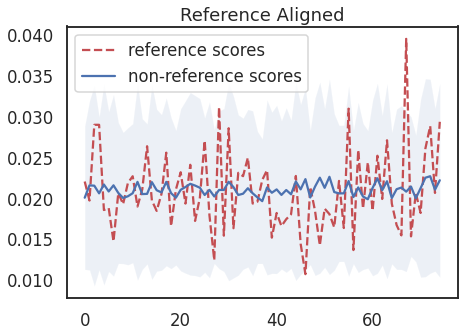

In [45]:
f, ax = plt.subplots(1,1,figsize=(7,5))
x = list(range(len(np.unique(subjs))))
ax.plot(x, reference_scores, label='reference scores', c='r', ls='--')
y = np.mean(other_scores, axis=1)
yerr = 2*np.std(other_scores, axis=1)
ax.plot(x, y, label='non-reference scores', c='b')
ax.fill_between(x, (y-yerr), (y+yerr), alpha=.1)
plt.legend()
plt.title('Reference Aligned')
plt.show()

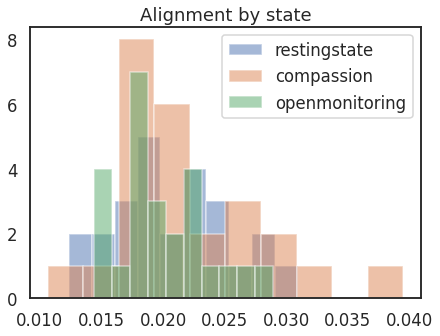

In [46]:
states = np.asarray([l[1] for l in labels])
score_dict = defaultdict(list)
for i in range(len(np.unique(subjs))):
    idx = np.asarray([i,i+1,i+2])
    scores = reference_scores[i]
    score_dict[states[i]].append(scores)
    
f, ax = plt.subplots(1,1,figsize=(7,5))
for key, scores in score_dict.items():
    ax.hist(scores, alpha=0.5, label=f'{key}')
plt.legend()
plt.title('Alignment by state')
plt.show()

In [47]:
reference_scores2 = []
other_scores2 = []
for i in range(len(np.unique(subjs))):
    i *= 3
    idx = np.asarray([i,i+1,i+2])
    Xs2, l2, subjs2 = switch_first(Xs, labels, subjs, idx)
    embs, _, _ = iterate_align(
        Xs2, l2, subjs2, thresh=0, max_iter=5, norm=False, mean_align=False
    )
    embs = np.asarray(embs)[:,:,:3]
    ref_score = np.mean([np.linalg.norm(embs[i] - embs[j]) / embs.shape[1] for i in range(3) for j in range(i+1,3)])
    other_score = [
        np.mean([np.linalg.norm(embs[i] - embs[j]) / embs.shape[1] for i in range(s*3,(s+1)*3) for j in range(i+1, (s+1)*3)])
        for s in range(len(np.unique(subjs))-1)
    ]
    reference_scores2.append(ref_score)
    other_scores2.append(other_score)

other_scores2 = np.asarray(other_scores2)
reference_scores2 = np.asarray(reference_scores2)


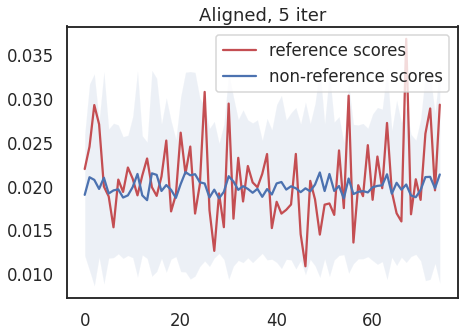

In [53]:
f, ax = plt.subplots(1,1,figsize=(7,5))
x = list(range(len(np.unique(subjs))))
ax.plot(x, reference_scores2, label='reference scores', c='r')
y = np.mean(other_scores2, axis=1)
yerr = 2*np.std(other_scores2, axis=1)
ax.plot(x, y, label='non-reference scores', c='b')
ax.fill_between(x, (y-yerr), (y+yerr), alpha=.1)
plt.legend()
plt.title('Aligned, 5 iter')
plt.show()

In [49]:
reference_scores3 = []
other_scores3 = []
for i in range(len(np.unique(subjs))):
    i *= 3
    idx = np.asarray([i,i+1,i+2])
    Xs2, l2, subjs2 = switch_first(Xs, labels, subjs, idx)
    embs, _, _ = iterate_align(
        Xs2, l2, subjs2, thresh=0, max_iter=5, norm=False, mean_align=False, reference_align=False
    )
    embs = np.asarray(embs)[:,:,:3]
    ref_score = np.mean([np.linalg.norm(embs[i] - embs[j]) / embs.shape[1] for i in range(3) for j in range(i+1,3)])
    other_score = [
        np.mean([np.linalg.norm(embs[i] - embs[j]) / embs.shape[1] for i in range(s*3,(s+1)*3) for j in range(i+1, (s+1)*3)])
        for s in range(len(np.unique(subjs))-1)
    ]
    reference_scores3.append(ref_score)
    other_scores3.append(other_score)

other_scores3 = np.asarray(other_scores3)
reference_scores3 = np.asarray(reference_scores3)


In [60]:
other_scores2[:3,:5]

array([[0.02192967, 0.01863988, 0.02110938, 0.02576951, 0.01488813],
       [0.02448079, 0.02109193, 0.02896031, 0.0283709 , 0.01732113],
       [0.02922796, 0.02013323, 0.02467442, 0.02878234, 0.02034882]])

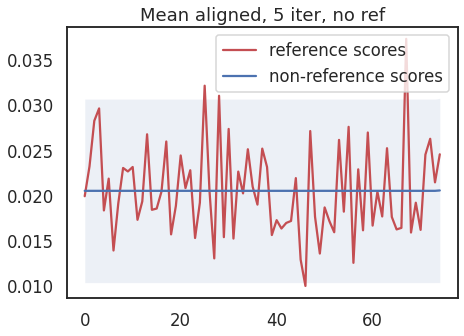

In [55]:
f, ax = plt.subplots(1,1,figsize=(7,5))
x = list(range(len(np.unique(subjs))))
ax.plot(x, reference_scores3, label='reference scores', c='r')
y = np.mean(other_scores3, axis=1)
yerr = 2*np.std(other_scores3, axis=1)
ax.plot(x, y, label='non-reference scores', c='b')
ax.fill_between(x, (y-yerr), (y+yerr), alpha=.1)
plt.legend()
plt.title('Mean aligned, 5 iter, no ref')
plt.show()

In [51]:
reference_scores4 = []
other_scores4 = []
for i in range(len(np.unique(subjs))):
    i *= 3
    idx = np.asarray([i,i+1,i+2])
    Xs2, l2, subjs2 = switch_first(Xs, labels, subjs, idx)
    embs, _, _ = iterate_align(
        Xs2, l2, subjs2, thresh=0, max_iter=5, norm=False, mean_align=True
    )
    embs = np.asarray(embs)[:,:,:3]
    ref_score = np.mean([np.linalg.norm(embs[k] - embs[j]) / embs.shape[1] for k in range(3) for j in range(k+1,3)])
    other_score = [
        np.mean([np.linalg.norm(embs[k] - embs[j]) / embs.shape[1] for k in range(s*3,(s+1)*3) for j in range(k+1, (s+1)*3)])
        for s in range(1, len(np.unique(subjs)))
    ]
    reference_scores4.append(ref_score)
    other_scores4.append(other_score)

other_scores4 = np.asarray(other_scores4)
reference_scores4 = np.asarray(reference_scores4)

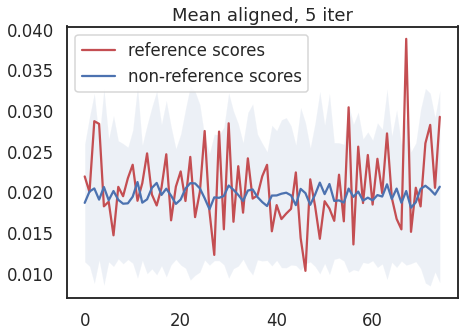

In [54]:
f, ax = plt.subplots(1,1,figsize=(7,5))
x = list(range(len(np.unique(subjs))))
ax.plot(x, reference_scores4, label='reference scores', c='r')
y = np.mean(other_scores4, axis=1)
yerr = 2*np.std(other_scores4, axis=1)
ax.plot(x, y, label='non-reference scores', c='b')
ax.fill_between(x, (y-yerr), (y+yerr), alpha=.1)
plt.legend()
plt.title('Mean aligned, 5 iter')
plt.show()

## Alignment over iterations

In [57]:
n_iter = 10
Zs = Xs / np.linalg.norm(Xs, axis=1, keepdims=True)
embs, _, _, obs = iterate_align(
    Zs[:6], labels[:6], subjs[:6], thresh=0, max_iter=n_iter, norm=False, mean_align=False, debug=True
)

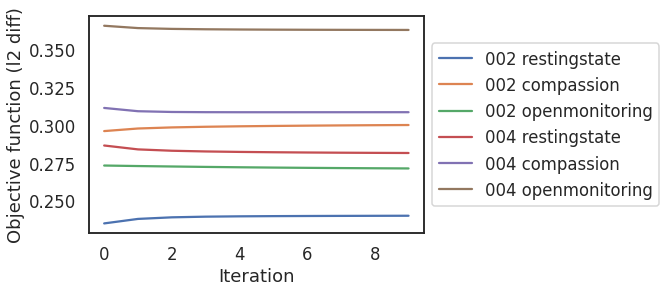

In [58]:
f, ax = plt.subplots(1,1)
for i, subj in enumerate(subjs[:6]):
    label = f'{subj} {labels[i][1]}'
    ax.plot(np.arange(len(obs)), np.asarray(obs)[:, i], label=label)
plt.ylabel('Objective function (l2 diff)')
plt.xlabel('Iteration')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [59]:
Zs = Xs / np.linalg.norm(Xs, axis=1, keepdims=True)
Zs2 = np.concatenate((Zs[3:6], Zs[:3]))
labels2 = np.vstack((labels[3:6], labels[:3]))
subjs2 = np.hstack((subjs[3:6], subjs[:3]))

In [60]:
n_iter = 10
embs, _, _, obs = iterate_align(
    Zs2, labels2, subjs2, thresh=0, max_iter=n_iter, norm=False, mean_align=False, debug=True
)

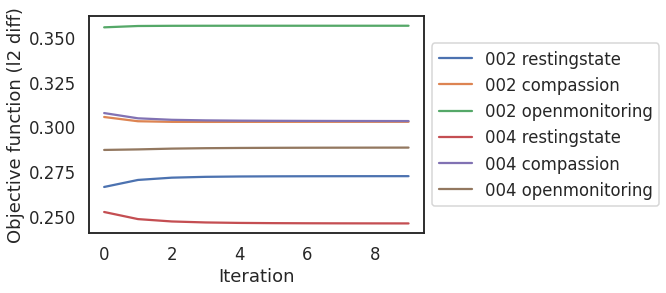

In [61]:
f, ax = plt.subplots(1,1)
for i, subj in enumerate(subjs[:6]):
    label = f'{subj} {labels2[i][1]}'
    ax.plot(np.arange(len(obs)), np.asarray(obs)[:, i], label=label)
plt.ylabel('Objective function (l2 diff)')
plt.xlabel('Iteration')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

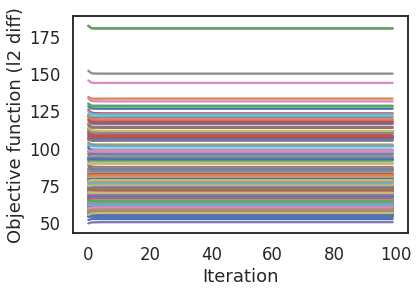

In [21]:
f, ax = plt.subplots(1,1)
ax.plot(np.arange(len(obs)), obs)
plt.ylabel('Objective function (l2 diff)')
plt.xlabel('Iteration')
plt.show()

In [23]:
len(obs[0])

225